# Example: Water discharge data analysis

In [2]:
%load_ext autoreload

%autoreload 2

%matplotlib inline

In [3]:
try:
    from oatlib import sensor, oat_utils
except ImportError:
    !pip install oatlib

In [4]:
import requests
import json
from oatlib import sensor, method, oat_utils
from dateutil import parser
import matplotlib.pyplot as plt
from statistics import stdev
import scipy.stats as st
import numpy as np

⚒ Load data from csv using OAT

In [5]:
SENSOR = sensor.Sensor(
    name='procedure_name',
    prop='water-discharge',
    unit='m3/s'
)
SENSOR.ts_from_csv(
    'https://raw.githubusercontent.com/istSOS/workshop/master/oat/data/Q_VED_ISO_20180101000000000000.dat',
    qualitycol=2,
    sep=',',
    skiprows=1
)

In [6]:
from dateutil import relativedelta
SENSOR = sensor.Sensor.from_istsos_with_ts(
    service = 'http://istsos.org/istsos/hydro', 
    procedure='Q_MAG_LOD',
    observed_property='urn:ogc:def:parameter:x-istsos:1.0:river:water:discharge',
    event_time='2019-01-01T01:00:00+0100/2022-01-01T00:00:00+0100',
    #aggregate_function='AVG',
    #aggregate_interval='PT10M',
    basic_auth=None, 
    srid=4326,
    verifySSL=True,
    delta=relativedelta.relativedelta(days=15)
)

/home/maxi/GIT/istSOS_2.4.0_workshop_mexico_2020/venv/lib/python3.8/site-packages/oatlib/sensor.py:227: UserWarning: gdal package is not installed thus SRS reprojection is not enableD
  warnings.warn("gdal package is not installed thus SRS reprojection is not enableD")


Retrieving data...2022-01-01 00:00:00+01:00

⚒ take a look at the series

In [7]:
SENSOR.ts.head(10)

,data,quality
time,,
2019-01-01 01:10:00+01:00,2.1141,330
2019-01-01 01:20:00+01:00,2.1141,330
2019-01-01 01:30:00+01:00,2.1141,330
2019-01-01 01:40:00+01:00,2.1141,330
2019-01-01 01:50:00+01:00,2.1141,330
2019-01-01 02:00:00+01:00,2.1141,330
2019-01-01 02:10:00+01:00,2.1141,330
2019-01-01 02:20:00+01:00,2.1141,330
2019-01-01 02:30:00+01:00,2.1141,330


⚒ Monthly resample using mean() function 

In [8]:
SENSOR_M = SENSOR.copy()
SENSOR_M.ts = SENSOR.ts.resample("M").mean()

⚒ Plot monthly Q

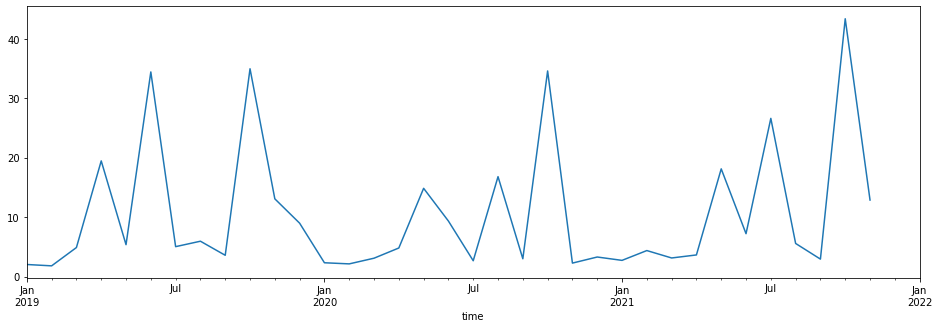

In [9]:
SENSOR_M.ts['data'].plot(figsize=(16,5))

## Multi-year monthly means with groupby

⚒ First step will be to add another column to our DataFrame with month numbers:

In [10]:
SENSOR.ts['mon'] = SENSOR.ts.index.month

⚒ Now we can use [groupby](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html) to group our values by months and calculate mean for each of the groups (month in our case):

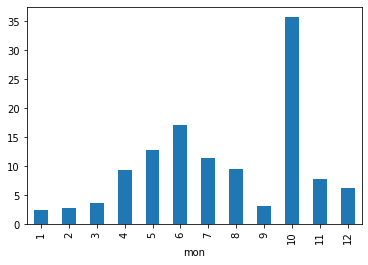

In [11]:
monmean = SENSOR.ts.groupby('mon').aggregate('mean')
monmean['data'].plot(kind='bar')

⚒ In order to see what is going on there, it is useful to look at the [box plots](https://en.wikipedia.org/wiki/Box_plot) for every month:

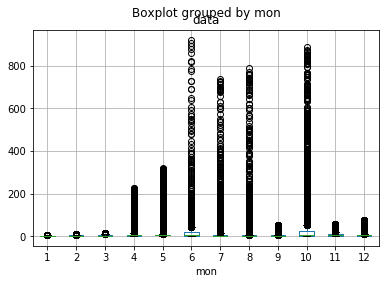

In [12]:
ax = SENSOR.ts.boxplot(column=['data'], by='mon')

⚒ ..and calculate general series statistics

In [13]:
method.Statistics().execute(SENSOR)

{'data': {'count': 145844.0,
  'mean': 9.78599594841063,
  'std': 35.4278411453466,
  'min': 1.0568,
  '25%': 2.0804,
  '50%': 3.2472,
  '75%': 6.1465,
  'max': 923.1615}}

## Calculate flow duration curve

The flow-duration curve is a cumulative frequency curve that shows the percent of time specified discharges were equaled or exceeded during a given period. It combines in one curve the flow characteristics of a stream throughout the range of discharge, without regard to the sequence of occurrence.

The Flow Duration Curve is one of the most fundamental pieces of information that feeds into the design of a hydropower project, so for anyone that wants to understand the how’s and why’s of hydropower design, understanding the flow duration curve is a good place to start.

Q95 means the flow rate equalled or exceeded for 95% of the time

Flow rates between 
- Q0 and Q10 are considered high flow rates, 
  - Q0 to Q1 would be extreme flood events. 
- Q10 to Q70 would be the ‘medium’ range of flows
- Q70 to Q100 are the ‘low flows’
  - Q95 to Q100 are the low-flow draught flows


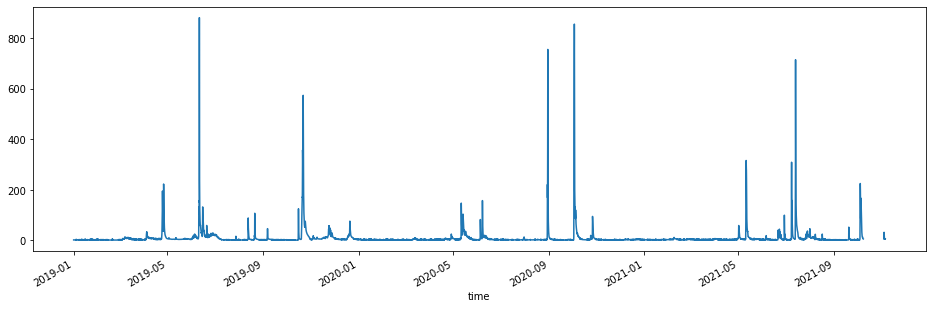

In [14]:
SENSOR_H = SENSOR.copy()
SENSOR_H.ts = SENSOR.ts.resample("H").mean()
SENSOR_H.ts['data'].plot(figsize=(16,5))

In [15]:
def fdc(df):
    '''
    Generate flow duration curve for hydrologic time series data
    
    df = pandas dataframe containing discharge data
    '''
    data=df.dropna().values
    #sort the values:
    sortQ = np.sort(data)
    #calculate the ranks:
    ranks = st.rankdata(sortQ, method='average')[::-1]
    #normalise the ranks:
    prob = [100*(ranks[i]/(len(sortQ)+1)) for i in range(len(sortQ)) ]
    # return [prob,sortQ]
    
    plt.plot(prob, sortQ,'-',color='red')
    plt.rcParams["figure.figsize"] = (16,5)
    plt.yscale('log')
    plt.grid(which = 'both')
    plt.xlabel('% of time that indicated discharge was exceeded or equaled')
    plt.ylabel('discharge')
    plt.xticks(range(0,100,5))
    plt.legend()
    plt.title('Flow Duration Curve')

No handles with labels found to put in legend.


Text(95, 1, 'Draugth Flow')

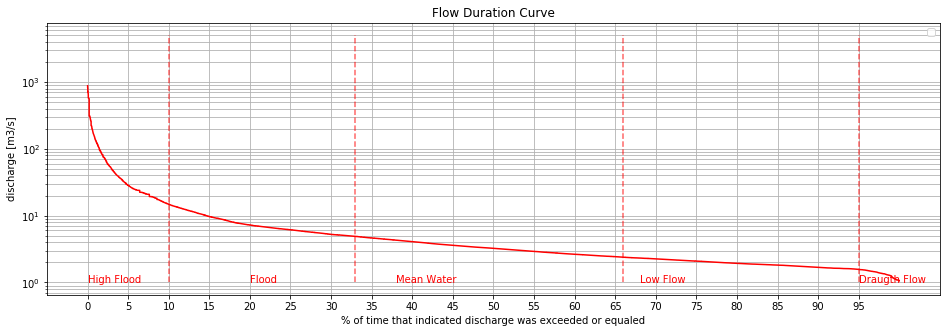

In [56]:
fdc(SENSOR_H.ts['data'])
plt.ylabel('discharge [m3/s]')
#add quantile lines
plt.plot([10,10],[1e0,5e3],'r--',alpha=0.6)
plt.plot([33,33],[1e0,5e3],'r--',alpha=0.6)
plt.plot([66,66],[1e0,5e3],'r--',alpha=0.6)
plt.plot([95,95],[1e0,5e3],'r--',alpha=0.6)
plt.text(0,1,'High Flood',color='red')
plt.text(20,1,'Flood',color='red')
plt.text(38,1,'Mean Water',color='red')
plt.text(68,1,'Low Flow',color='red')
plt.text(95,1,'Draugth Flow',color='red')
# plt.ylim([1e-7,5e-3])

## Hydropower

What is the minimum head and flow required?
The answer to this depends very much on what return on your investment you want.

For a commercially viable site it would normally need to be at least 25 kW maximum power output.

For a low-head micro hydropower system you would need at least 2 metres of gross head and an average flow rate of 2.07 m3/s.<br>
To put this in context this would be a small river that was approximately 7 metres wide and around 1 metre deep in the middle.

For a site with 25 metres head a much lower average flow rate of 166 litres / second would be needed.<br>This would be a large stream of 2 – 3 metres width and around 400 mm deep in the middle.

It is technically possible to develop smaller hydropower sites with lower power outputs, but the economics start to get challenging.<br>
This is particularly true for low-head sites; when the head drops to 1.5 metres it isn’t normally possible to get any kind of return on investment, though the site could still be technically developed using Archimedean screws or modern waterwheels.

25 kW would normally be considered the minimum for a commercial project, though a 10 kW system can still produce an acceptable return if the civil engineering works are simple (hence don’t cost much).<br>
5 kW systems are not normally viable, but the figures are shown for interest and may be useful for sites that can generate value from non-tangible benefits such as attracting visitors or positive publicity.

-----

It is important that hydropower systems are designed to cope with such extreme flows.<br>
Flows from Q10 to Q70 would be the ‘medium’ range of flows and you would want your hydropower system to operate efficiently right across these flow rates. 

Flow rates from Q70 to Q100 are the ‘low flows’ when hydropower systems will just be operating but at a low power output, and as you move further to the right on the FDC hydro systems will begin to shut down due to low flow. 


https://www.renewablesfirst.co.uk/hydropower/hydropower-learning-centre/head-and-flow-detailed-review/





---

## ASSIGNMENT:
Replicate the Multi-year monthly means with data from W_MAGGGIA from the CSV file W_MAGGIA in istsos folder ;-)

https://raw.githubusercontent.com/istSOS/workshop/master/istsos/W_MAGGGIA.csv